In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg

## Import dataset

Lung Segmented images are saved locally first and then imported

---




In [3]:
ct_classes = os.listdir("/content/drive/MyDrive/ME 781 Project/Processed_Images/train/")
ct_classes
'''
ct_classes: list of classes for classification. Here, only 2 classes ['covid', 'non-covid'] are present
'''

"\nct_classes: list of classes for classification. Here, only 2 classes ['covid', 'non-covid'] are present\n"

In [4]:
base_dir = "/content/drive/MyDrive/ME 781 Project/Processed_Images"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [5]:
def count_images(train_dir, val_dir, ct_classes):
    '''
    Function:
    count_images:

        Input variables:
        train_dir: Directory corresponding to training data
        val_dir: Directory corresponding to validation data
        ct_classes: list of classes for classification

        Output:
        Calculate and prints the number of images per class in both train and validation dataset
    '''

    train_fnames = {}
    for cls in ct_classes:
        cls_dir = os.path.join(train_dir, cls)
        train_fnames[cls] = os.listdir(cls_dir)

    val_fnames = {}
    for cls in ct_classes:
        cls_dir = os.path.join(val_dir, cls)
        val_fnames[cls] = os.listdir(cls_dir)
        
    print('CT Dataset')
    print()
    print('Train:')
    for key in train_fnames.keys():
        print(key, ':', len(train_fnames[key]))

    print()

    print('Val:')
    for key in val_fnames.keys():
        print(key, ':', len(val_fnames[key]))

count_images(train_dir, val_dir, ct_classes)

CT Dataset

Train:
covid : 337
non-covid : 385

Val:
covid : 12
non-covid : 12


## Pre-processing

In [6]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(#rescale=1.0/255.0, # preprocessing_function=pre_func, 
                             samplewise_center=True, samplewise_std_normalization=True
                             )
'''
datagen : Learns image parametrs to scale 
'''

'\ndatagen : Learns image parametrs to scale \n'

In [7]:
# prepare generators to scale images
'''
train_generator: Imports and scales the training images
val_generator: Imports and scales the validation images
'''
train_generator = datagen.flow_from_directory(train_dir, target_size=(256, 256), color_mode='rgb', 
                                                    classes=ct_classes,
                                                    batch_size=16, shuffle=True)
val_generator = datagen.flow_from_directory(val_dir, target_size=(256, 256), color_mode='rgb', 
                                                    classes=ct_classes, batch_size=16, shuffle=True)
print('Batches train=%d, val=%d' % (len(train_generator), len(val_generator)))

Found 722 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Batches train=46, val=2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


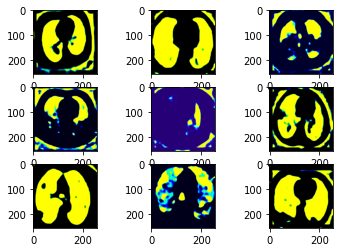

In [8]:
for train_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.imshow(train_batch[0][i].reshape(256,256,3),)

    # show the plot
    plt.show()
    break 
plt.show()

## CovidNET

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model

from tensorflow.keras import models
from tensorflow.keras import backend as K
from keras.applications.densenet import DenseNet121
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [10]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
'''
base_model : DenseNet121 architecture is used that is pretrained on ImageNet database 
'''

29089792/29084464 [==============================] - 1s 0us/step


'\nbase_model : DenseNet121 architecture is used that is pretrained on ImageNet database \n'

In [11]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['acc', 'mse'])

In [ ]:
history = model.fit(train_generator, validation_data=val_generator, epochs=100, callbacks=[
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_lr=1e-05)
])
# EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, 
#               mode='auto', baseline=None, restore_best_weights=False)
'''
Model is fitted with adam optimizer and categorical crossentropy loss with 200 epochs 
and batch size = 16 with lr is 1e-05 and also ReduceLROnPlateau is also being used
'''

Epoch 1/100
46/46 [==============================] - 11s 247ms/step - loss: 1.6107 - acc: 0.5582 - mse: 0.3554 - val_loss: 38.4065 - val_acc: 0.5000 - val_mse: 0.5000
Epoch 2/100
46/46 [==============================] - 10s 218ms/step - loss: 0.9239 - acc: 0.6066 - mse: 0.2800 - val_loss: 78.0129 - val_acc: 0.5000 - val_mse: 0.5000
Epoch 3/100
46/46 [==============================] - 10s 219ms/step - loss: 0.6066 - acc: 0.6939 - mse: 0.2054 - val_loss: 5.1002 - val_acc: 0.5000 - val_mse: 0.4706
Epoch 4/100
46/46 [==============================] - 10s 217ms/step - loss: 0.6134 - acc: 0.7535 - mse: 0.1851 - val_loss: 1.9840 - val_acc: 0.6250 - val_mse: 0.3590
Epoch 5/100
46/46 [==============================] - 10s 215ms/step - loss: 0.5780 - acc: 0.7632 - mse: 0.1760 - val_loss: 0.9667 - val_acc: 0.7083 - val_mse: 0.2609
Epoch 6/100
46/46 [==============================] - 10s 214ms/step - loss: 0.5111 - acc: 0.7756 - mse: 0.1615 - val_loss: 0.6739 - val_acc: 0.6667 - val_mse: 0.2352
Ep

'\nModel is fitted with adam optimizer and categorical crossentropy loss with 200 epochs \nand batch size = 16 with lr is 1e-05 and also ReduceLROnPlateau is also being used\n'